<a href="https://colab.research.google.com/github/Shiyi-Xia/NLP_ESS_2022/blob/main/Tutorial_Seven_(R)_Embedding_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification using Embeddings

*This tutorial was originally created by Burt Monroe for his prior work with the Essex Summer School. I've updated and modified it.*

In this notebook, we'll update our classifier to include an embedding layer where we estimate the embeddings as part of the layer. After completing this notebook, you should be familar with:


1. Estimate a deep learning model with an embedding layer.
2. Model raw text through TextVectorization
3. Visualize Embeddings

#### Setup Instructions:
This notebook was designed to run in a clean R runtime within Google Colab. Before running any of the code below, go up to the menu at the top of the window and click "runtime," then, from the dropdown, click "Disconnect and Delete Runtime". Then, reconnect. That should get everything set up to run smoothly. 


## Setup

In [ ]:
install.packages("keras") # install R library for keras; this installs dependencies we'll need, including tensorflow

library(tensorflow) # load R library for tensorflow
library(keras) # load R library for keras

tf$constant("Hello Tensorflow") # check that tensorflow is working

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



tf.Tensor(b'Hello Tensorflow', shape=(), dtype=string)

We now need to add a new package, `tfhub`. This is the Tensorflow Hub, which is a repository of reusable machine learning models. `tfhub` is an R package that provides access to all of the models retained on Tensorflow Hub. 

In [ ]:
install.packages("tfdatasets")
library(tfdatasets)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Load the IMDB data


In [ ]:
url <- "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset <- get_file(
  "aclImdb_v1",
  url,
  untar = TRUE,
  cache_dir = '.',
  cache_subdir = ''
)

In [ ]:
dataset_dir <- file.path("aclImdb")
list.files(dataset_dir)


[1] "imdb.vocab" "imdbEr.txt" "README"     "test"       "train"

In [ ]:
train_dir <- file.path(dataset_dir, 'train')
list.files(train_dir)

[1] "labeledBow.feat" "neg"             "pos"             "unsup"          
[5] "unsupBow.feat"   "urls_neg.txt"    "urls_pos.txt"    "urls_unsup.txt"

In [ ]:
sample_file <- file.path(train_dir, 'pos/1181_9.txt')
readr::read_file(sample_file)

[1] "Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived."

In [ ]:
remove_dir <- file.path(train_dir, 'unsup')
unlink(remove_dir, recursive = TRUE)

In [ ]:
batch_size <- 32
seed <- 42

raw_train_ds <- text_dataset_from_directory(
  'aclImdb/train',
  batch_size = batch_size,
  validation_split = 0.2,
  subset = 'training',
  seed = seed
)

In [ ]:
raw_val_ds <- text_dataset_from_directory(
  'aclImdb/train',
  batch_size = batch_size,
  validation_split = 0.2,
  subset = 'validation',
  seed = seed
)

raw_test_ds <- text_dataset_from_directory(
  'aclImdb/test',
  batch_size = batch_size
)

## The TextVectorization layer - an example

To illustrate with the TextVectorization layer in Keras does, consider a simple example.

In [ ]:
input_data <- c("Would you like them in a house?", 
                "Would you like them with a mouse?", 
                "I do not like them in a house.",
                "I do not like them with a mouse.",
                "I do not like them here or there.",
                "I do not like them anywhere.")
text_vectorization <- layer_text_vectorization()

# apply
text_vectorization %>% adapt(input_data)

# compare the first document
input_data[1]
text_vectorization(matrix(input_data[1], ncol=1))


[1] "Would you like them in a house?"

tf.Tensor([[ 9  8  3  2 12  7 13]], shape=(1, 7), dtype=int64)

In [ ]:
# now look at all the documents
input_data
text_vectorization(matrix(input_data, ncol=1))

[1] "Would you like them in a house?"   "Would you like them with a mouse?"
[3] "I do not like them in a house."    "I do not like them with a mouse." 
[5] "I do not like them here or there." "I do not like them anywhere."

tf.Tensor(
[[ 9  8  3  2 12  7 13  0]
 [ 9  8  3  2 10  7 11  0]
 [ 5  6  4  3  2 12  7 13]
 [ 5  6  4  3  2 10  7 11]
 [ 5  6  4  3  2 16 15 14]
 [ 5  6  4  3  2 17  0  0]], shape=(6, 8), dtype=int64)

The TextVectorization layer tokenizes the input text and replaces each with an integer indexing its location in the vocabulary. The vocabulary is built by `adapt`. The output is our matrix/array/tensor of integers. Note that they have to be the same length, so the shorter ones are padded with 0s. We must do some combination of this, cutting off texts at a maximum length, or similar to have them be the same length here.

We've mostly sidestepped the notion of "tensors" up to now, but there it is, right in front of you, so I need to address it. That tensor looks just like a matrix, because it is. A matrix is a special example, in this case a tensor of shape 6 x 8. A tensor can take that in three or more dimensions. Our example above has one vector (row) for every document/sentence in the data. Imagine each example was something two dimensional, like an image -- say, an 10 x 8 grid of on and off pixels. Now each of the 6 "rows" of the dataset is a 10x8 "matrix", and stacked together they form a 6x10x8 tensor. As might be clear from the name, tensors are the inputs and outputs of  model layers in Tensorflow.

## Apply TextVectorization

You can send a different tokenizer to the TextVectorization layer -- and the reviews do have some detritus like html tags that probably should be removed -- but we'll just use the default.

Now let's set up our vectorize_layer for real. We'll set our maximum vocabulary and our maximum review length.

In [ ]:
max_features <- 10000
sequence_length <- 250

vectorize_layer <- layer_text_vectorization(
  max_tokens = max_features,
  output_mode = "int",
  output_sequence_length = sequence_length
)

We'll call the adapt function to build the vocabulary from the text of the reviews.



In [ ]:
train_text <- raw_train_ds %>%
  dataset_map(function(text, label) text)
  
vectorize_layer %>% adapt(train_text)

In [ ]:
vectorize_text <- function(text, label) {
  text <- tf$expand_dims(text, -1L)
  list(vectorize_layer(text), label)
}

In [ ]:
train_ds <- raw_train_ds %>% dataset_map(vectorize_text)
val_ds <- raw_val_ds %>% dataset_map(vectorize_text)
test_ds <- raw_test_ds %>% dataset_map(vectorize_text)

## Performance Considerations

In [ ]:
AUTOTUNE <- tf$data$AUTOTUNE

train_ds <- train_ds %>%
  dataset_cache() %>%
  dataset_prefetch(buffer_size = AUTOTUNE)
val_ds <- val_ds %>%
  dataset_cache() %>%
  dataset_prefetch(buffer_size = AUTOTUNE)
test_ds <- test_ds %>%
  dataset_cache() %>%
  dataset_prefetch(buffer_size = AUTOTUNE)

# Create the Model

Recall in our baseline model, we had 5000 inputs -- for each document, 1 for every word appearing and 0 for every word not -- that fed into a Dense layer of 16 nodes (for 5000 x 16 = 80000  weights).

Now we have for document an input of 100 integers (the maximum length, padded if shorter with 0s). Each integer represents a word. The embedding layer maps each integer into its 16-dimensional embedding vector (16 numbers), so we now have 100 lookups from the 5000x16 embeddings as outputs. The GlobalAveragePooling1D layer averages the 100 embeddings yielding 16 outputs.

In the first case, the document has words squashed together (multihot) and then compressed into 16 numbers, the activations of the first Dense layer. In the second case, the words are compressed into 16 numbers by the embedding, and then squashed together in the document by the pooling layer. Both take 80000 parameters to do.

In [ ]:
embedding_dim <- 16


In [ ]:
model <- keras_model_sequential() %>%
  layer_embedding(max_features + 1, embedding_dim) %>%
  layer_global_average_pooling_1d() %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dense(units = 1)

summary(model)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 embedding (Embedding)              (None, None, 16)                160016      
 global_average_pooling1d (GlobalAv  (None, 16)                     0           
 eragePooling1D)                                                                
 dense_1 (Dense)                    (None, 16)                      272         
 dense (Dense)                      (None, 1)                       17          
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
________________________________________________________________________________


In [ ]:
model %>% compile(
  optimizer = 'adam',
  loss = 'binary_crossentropy',
  metrics = c('accuracy')
)

In [ ]:
history <- model %>% fit(
  train_ds,
  epochs = 50,
  validation_data = val_ds,
  verbose = 1
)

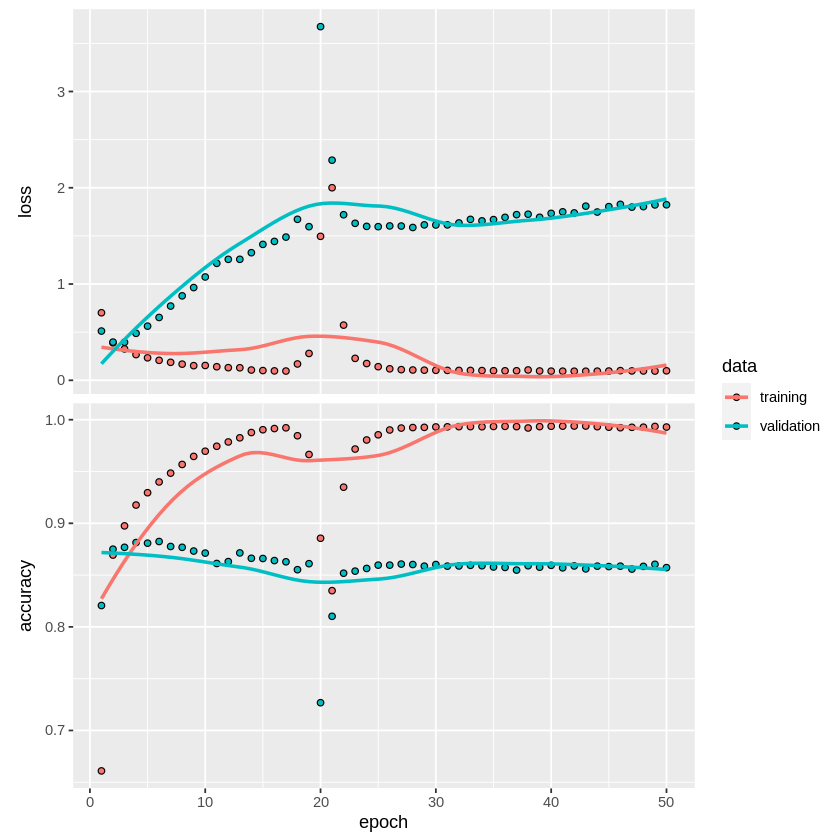

In [ ]:
plot(history)

In [ ]:
results <- model %>% evaluate(test_ds, verbose = 2)

In [ ]:
results

loss accuracy 
2.150304 0.834920

That looks overfit, and like we could probably cut things off much earlier. There's that weird jump around 20 epochs, so let's go after that to about 30. We're not doing as well, but one reason for that might be that we are clipping the reviews at 250 tokens with max_sequence_length above. In doing so, we are probably losing the reviews that end with their rating (and thus increase the accuracy of some of our more naive approaches). Take some time and play around as an exercise with the specifications to see where we might be able to improve.

# Embeddings!

Let's look at those embeddings.

In [ ]:
embedding_matrix <- get_weights(model)[[1]]
vocab <- get_vocabulary(vectorize_layer)

In [ ]:
index_val <- 1000
writeLines(paste("The word: ", vocab[index_val], sep = ""))
cat("Its vector values:", embedding_matrix[index_val,])

The word: front
Its vector values: 0.07260886 0.05127152 0.02541481 0.09004423 -0.08205149 0.04564973 -0.01295586 0.01078093 -0.04226513 0.07979143 -0.03382564 -0.02636646 -0.0973067 0.03233436 -0.06513187 0.006945741

In [ ]:
row.names(embedding_matrix) <- c("UNK", vocab)

In [ ]:
install.packages("text2vec")
library(text2vec)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘MatrixExtra’, ‘float’, ‘RhpcBLASctl’, ‘RcppArmadillo’, ‘rsparse’, ‘mlapi’, ‘lgr’



Attaching package: ‘text2vec’


The following object is masked from ‘package:tfdatasets’:

    fit


The following objects are masked from ‘package:keras’:

    fit, normalize




In [ ]:
# little function from Daniel Falbel
find_similar_words <- function(word, embedding_matrix, n = 5) {
  similarities <- embedding_matrix[word, , drop = FALSE] %>%
    sim2(embedding_matrix, y = ., method = "cosine")
  
  similarities[,1] %>% sort(decreasing = TRUE) %>% head(n)
}

In [ ]:
find_similar_words("king", embedding_matrix)

king    simply   charles   stiller   vicious 
1.0000000 0.9940392 0.9936592 0.9933528 0.9921221

In [ ]:
find_similar_words("queen", embedding_matrix)

queen  captures   account    lifebr everyones 
1.0000000 0.9313150 0.9260837 0.9259067 0.9253065